# Severity component 

In [22]:
# import libraries
# NOTE: global_vars should be edited to include local paths and credentials before use.
import ignore.global_vars as gv
import db_tools as dbt
import pandas as pd
import sqlalchemy
import sys
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import poisson, nbinom, weibull_min, gamma
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from shapely import wkt
import os


In [10]:
# open connection and get table names
table_names = dbt.query(
    "SELECT table_name FROM information_schema.tables WHERE table_schema='public'"
)
print(table_names)


Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 12 rows
                             table_name
0                     census_resilience
1                     geography_columns
2                      geometry_columns
3                       spatial_ref_sys
4              POISSON_FREQUENCY_PARAMS
5               nri_shape_census_tracts
6                 disaster_risk_spatial
7              noaa_stormevents_ftp_all
8                   NOAA_STORM_EPISODES
9        disaster_risk_counties_spatial
10  disaster_risk_counties_event_counts
11                    NOAA_STORM_EVENTS


In [11]:

df_noaa_episodes = dbt.query('SELECT * FROM "NOAA_STORM_EPISODES"')
df_noaa_events = dbt.query('SELECT * FROM "NOAA_STORM_EVENTS"')
df_census = dbt.query('SELECT * FROM "census_resilience"')

Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 107094 rows
Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 1500308 rows
Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 3144 rows


In [12]:
df_noaa_episodes.sample(3)

,county_fips,year,event_count,total_deaths_direct,total_deaths_indirect,total_injuries_direct,total_injuries_indirect,event_types,first_event_date
90543,48145,2010,1,0,0,0,4,Winter Weather,2010-01-07
34157,20049,2018,0,0,0,0,0,,NaT
43151,24011,2016,1,2,0,12,0,Winter Weather,2016-12-17


In [15]:
df_noaa_episodes.describe()

,year,event_count,total_deaths_direct,total_deaths_indirect,total_injuries_direct,total_injuries_indirect,first_event_date
count,107094.000000,107094.000000,107094.000000,107094.000000,107094.000000,107094.000000,16249
mean,2011.500000,0.206921,0.151092,0.038714,0.626440,0.142576,2011-05-28 06:43:02.854329600
min,1999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1999-01-01 00:00:00
25%,2005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005-07-23 00:00:00
50%,2011.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2011-01-25 00:00:00
75%,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017-06-18 00:00:00
max,2024.000000,29.000000,638.000000,145.000000,1404.000000,2400.000000,2024-12-31 00:00:00
std,7.500035,0.658732,2.733061,0.822014,9.960642,7.830179,NaN


In [13]:
df_noaa_events.sample(3)

,EPISODE_ID,EVENT_ID,EVENT_TYPE,CZ_FIPS,STATE_FIPS,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DATE,YEAR,CO_FIPS
582825,1501154,5688512,Winter Weather,043,26,0,0,0,0,None,1999-02-05,1999,26043
926334,1131601,5280740,Thunderstorm Wind,137,20,0,0,0,0,None,2002-04-10,2002,20137
693085,1093575,5139755,Thunderstorm Wind,031,31,0,0,0,0,1K,2000-04-19,2000,31031


In [16]:
df_noaa_events.describe()

,EPISODE_ID,EVENT_ID,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DATE,YEAR
count,1.500308e+06,1.500308e+06,1.500308e+06,1.500308e+06,1.500308e+06,1.500308e+06,1500308,1.500308e+06
mean,4.075823e+05,1.869403e+06,4.471615e-02,1.017724e-02,1.078512e-02,2.763433e-03,2012-07-09 20:04:27.458680576,2.012070e+03
min,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1999-01-01 00:00:00,1.999000e+03
25%,6.806900e+04,4.095498e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2006-06-08 00:00:00,2.006000e+03
50%,1.375250e+05,8.282040e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2012-06-16 00:00:00,2.012000e+03
75%,1.094970e+06,5.147453e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019-02-12 00:00:00,2.019000e+03
max,2.414827e+06,5.724920e+06,1.150000e+03,2.400000e+03,6.380000e+02,5.600000e+01,2024-12-31 00:00:00,2.024000e+03
std,5.439201e+05,2.129523e+06,2.340476e+00,2.079539e+00,6.264439e-01,1.048210e-01,NaN,7.416755e+00


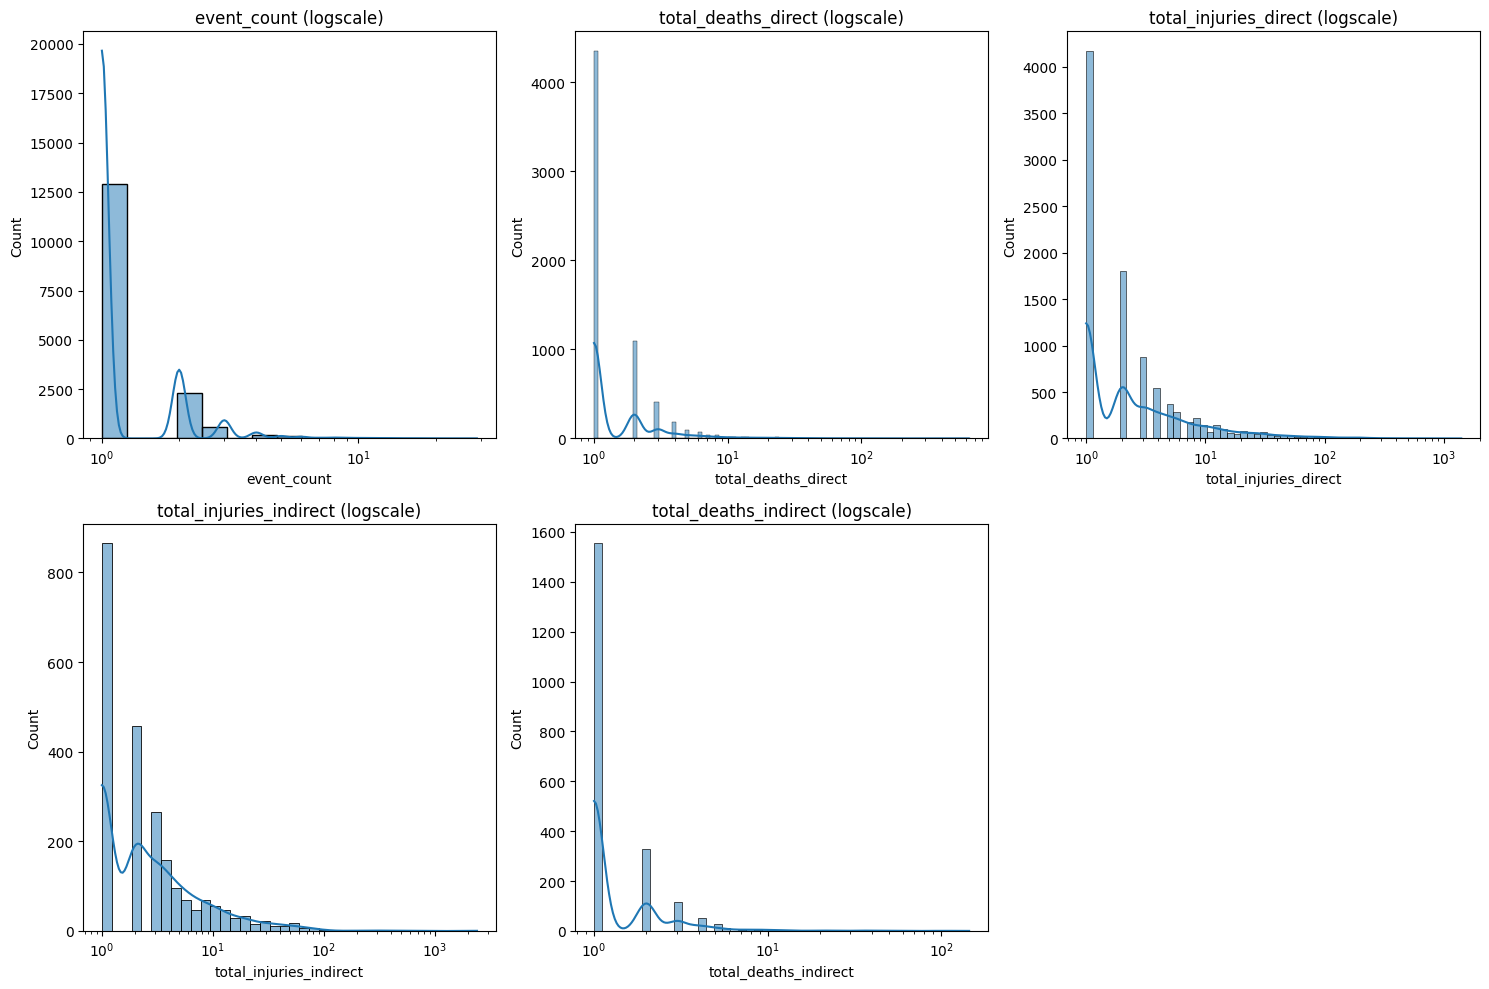

In [20]:
plot_vars = ['event_count', 'total_deaths_direct', 'total_injuries_direct', 'total_injuries_indirect', 'total_deaths_indirect']
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()
pick_vars = [var for var in plot_vars if var in df_noaa_episodes.columns]
for i, var in enumerate(pick_vars):
    if i < len(axes):
        data = df_noaa_episodes[var]
        data_non = data[data > 0]

        if len(data_non) > 0:
            sns.histplot(data_non, kde=True, log_scale=True, ax=axes[i])
            axes[i].set_title(f'{var} (logscale)')
            axes[i].set_xlabel(var)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Candidates for deaths/injuries
lognormal
gamma
weibull

lognormal eliminated due to graph above
